In [32]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams 
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler

In [33]:
df=pd.read_csv('tesla_stock.csv')
df.head()

,Date,Close/Last,Volume,Open,High,Low
0,01/06/2023,$113.06,220911100,$103,$114.39,$101.81
1,01/05/2023,$110.34,157986300,$110.51,$111.75,$107.1601
2,01/04/2023,$113.64,180389000,$109.11,$114.59,$107.52
3,01/03/2023,$108.1,231402800,$118.47,$118.8,$104.64
4,12/30/2022,$123.18,157777300,$119.95,$124.48,$119.75


In [34]:
df=df[['Date','Close/Last']]
df.head()

,Date,Close/Last
0,01/06/2023,$113.06
1,01/05/2023,$110.34
2,01/04/2023,$113.64
3,01/03/2023,$108.1
4,12/30/2022,$123.18


In [35]:
df.dtypes

Date          object
Close/Last    object
dtype: object

In [36]:
df = df.replace({'\$':''}, regex = True)

In [37]:
df = df.astype({"Close/Last": float})
df["Date"] = pd.to_datetime(df.Date, format="%m/%d/%Y")
df.dtypes

Date          datetime64[ns]
Close/Last           float64
dtype: object

In [38]:
df.index = df['Date']

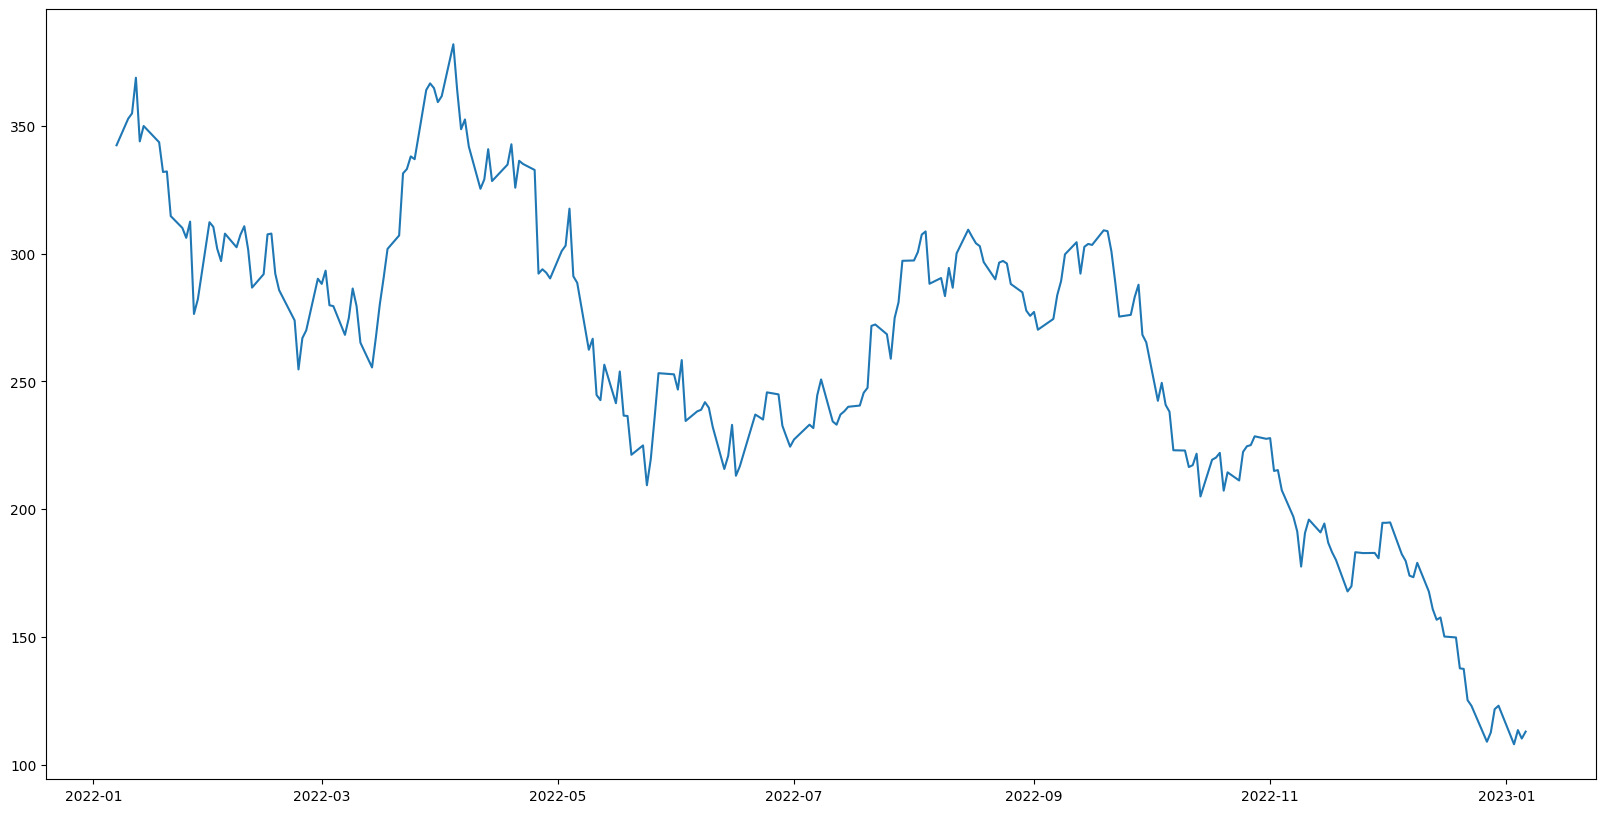

In [39]:
plt.plot(df["Close/Last"],label='Close Price history')

In [40]:
df = df.sort_index(ascending=True,axis=0)
data = pd.DataFrame(index=range(0,len(df)),columns=['Date','Close/Last'])
for i in range(0,len(data)):
    data["Date"][i]=df['Date'][i]
    data["Close/Last"][i]=df["Close/Last"][i]
data.head()

,Date,Close/Last
0,2022-01-07 00:00:00,342.32
1,2022-01-10 00:00:00,352.7066
2,2022-01-11 00:00:00,354.8
3,2022-01-12 00:00:00,368.74
4,2022-01-13 00:00:00,343.8533


In [41]:
scaler=MinMaxScaler(feature_range=(0,1))
data.index=data.Date
data.drop("Date",axis=1,inplace=True)
final_data = data.values
train_data=final_data[0:200,:]
valid_data=final_data[200:,:]
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_data)
x_train_data,y_train_data=[],[]
for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])


In [42]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(np.shape(x_train_data)[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))
model_data=data[len(data)-len(valid_data)-60:].values
model_data=model_data.reshape(-1,1)
model_data=scaler.transform(model_data)

In [43]:
x_train_data = np.asarray(x_train_data)
y_train_data = np.asarray(y_train_data)
lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)
X_test=[]
for i in range(60,model_data.shape[0]):
    X_test.append(model_data[i-60:i,0])
X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

140/140 - 6s - loss: 0.0214 - 6s/epoch - 41ms/step


In [44]:
predicted_stock_price=lstm_model.predict(X_test)
predicted_stock_price=scaler.inverse_transform(predicted_stock_price)

2/2 [==============================] - 1s 12ms/step


/tmp/ipykernel_145434/745233901.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=predicted_stock_price


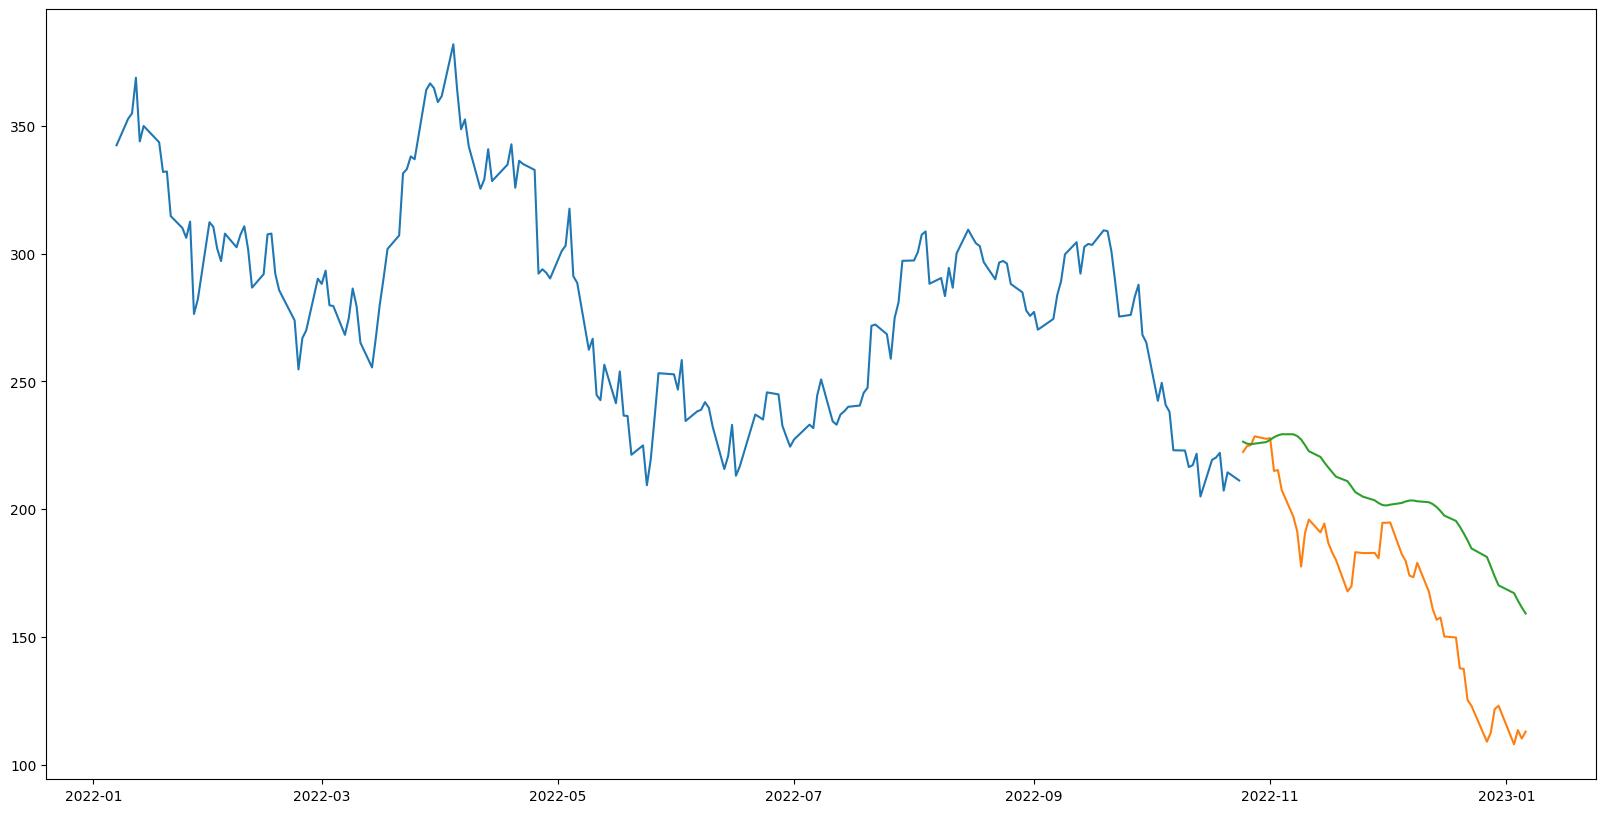

In [45]:
train_data=data[:200]
valid_data=data[200:]
valid_data['Predictions']=predicted_stock_price
plt.plot(train_data["Close/Last"])
plt.plot(valid_data[['Close/Last',"Predictions"]])